In [2]:
pip install rpy2

In [3]:
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import csv
from sklearn.metrics import jaccard_score
import csv
from rpy2 import robjects
plt.style.use('ggplot')

In [4]:
%load_ext rpy2.ipython

Data Set Information:

Dota 2 is a popular computer game with two teams of 5 players. At the start of the game each player chooses a unique hero with different strengths and weaknesses. The dataset is reasonably sparse as only 10 of 113 possible heroes are chosen in a given game. All games were played in a space of 2 hours on the 13th of August, 2016

The data was collected using: [Web Link](https://gist.github.com/da-steve101/1a7ae319448db431715bd75391a66e1b)


Attribute Information:

Each row of the dataset is a single game with the following features (in the order in the vector):
1. Team won the game (1 or -1)
2. Cluster ID (related to location)
3. Game mode (eg All Pick)
4. Game type (eg. Ranked)
5. 5- end: Each element is an indicator for a hero. Value of 1 indicates that a player from team '1' played as that hero and '-1' for the other team. Hero can be selected by only one player each game. This means that each row has five '1' and five '-1' values.

The hero to id mapping can be found here: [Web Link](https://github.com/kronusme/dota2-api/blob/master/data/heroes.json)

In [5]:
cp drive/MyDrive/Colab\ Notebooks/*.csv .

## Leemos los archivos con las etiquetas

In [6]:
df_Heroes=pd.read_csv('Heroes.csv') # files with ids of heroes
df_GameType=pd.read_csv('GameType.csv') 
df_ClusterID=pd.read_csv('ClusterID.csv')
df_GameMode=pd.read_csv('GameMode.csv')
#load the train data
df_dota_train=pd.read_csv('dota2Train.csv',header=None)

In [7]:
names_heroes=list(df_Heroes['name'])
features=['Winner','Region','Game_mode','Game_type']
df_dota_train.columns=features+names_heroes

In [8]:
dict_winner={1:'Radiant',-1:'Dire'}
dict_GameType=dict(zip(df_GameType.to_dict()['id'].values(),df_GameType.to_dict()['name'].values()))
dict_GameMode=dict(zip(df_GameMode.to_dict()['id'].values(),df_GameMode.to_dict()['name'].values()))
dict_ClusterID=dict(zip(df_ClusterID.to_dict()['id'].values(),df_ClusterID.to_dict()['name'].values()))
df_dota_train['Winner']=df_dota_train['Winner'].map(dict_winner)
df_dota_train['Game_type']=df_dota_train['Game_type'].map(dict_GameType)
df_dota_train['Game_mode']=df_dota_train['Game_mode'].map(dict_GameMode)
df_dota_train['Region']=df_dota_train['Region'].map(dict_ClusterID)

In [9]:
df_dota_train.head()

,Winner,Region,Game_mode,Game_type,antimage,axe,bane,bloodseeker,crystal_maiden,drow_ranger,earthshaker,juggernaut,mirana,nevermore,morphling,phantom_lancer,puck,pudge,razor,sand_king,storm_spirit,sven,tiny,vengefulspirit,windrunner,zuus,kunkka,None,lina,lich,lion,shadow_shaman,slardar,tidehunter,witch_doctor,riki,enigma,tinker,sniper,necrolyte,...,invoker,silencer,obsidian_destroyer,lycan,brewmaster,shadow_demon,lone_druid,chaos_knight,meepo,treant,ogre_magi,undying,rubick,disruptor,nyx_assassin,naga_siren,keeper_of_the_light,wisp,visage,slark,medusa,troll_warlord,centaur,magnataur,shredder,bristleback,tusk,skywrath_mage,abaddon,elder_titan,legion_commander,ember_spirit,earth_spirit,abyssal_underlord,terrorblade,phoenix,techies,oracle,winter_wyvern,arc_warden
0,Dire,China,Captains Mode,Tournament,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,-1,0,0,0,-1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,...,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Radiant,SoutheastAsia,Captains Mode,Tournament,0,0,0,1,0,-1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,-1,0,0,0,0,1,1,0,0,0,0,0,0,0,-1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Radiant,EuropeWest,Captains Mode,Tournament,0,0,0,1,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Radiant,SoutheastAsia,Captains Mode,Tournament,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0
4,Dire,Australia,Captains Mode,Tutorial,0,0,0,0,0,-1,0,0,-1,0,-1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Heroes que no fueron seleccionados

In [10]:
#Heroes con cero selecciones: 24 y 108
for i in range(5,117):
    t=np.sum(np.abs(df_dota_train.iloc[:,i]))
    if t==0:
        print(i)    

27
111


**Missing hero id 24**  
https://www.reddit.com/r/DotA2/comments/6jbspw/why_hero_with_id_24_doesnt_exist/  
https://liquipedia.net/dota2/MediaWiki:Dota2webapi-heroes.json

No hay valores para el heroe 24. En el archivo Heroes.csv se le asigno None,24,None.

## Plots exploratorios


### Los 10 heroes mas usados

In [11]:
#contamos las veces que aparece cada heroe
heroes_count={df_Heroes['localized_name'][h]:np.sum(np.abs(df_dota_train[df_dota_train.columns[h+4]])) for h in range(113)}
# ordenamos los heroes en forma descendente por 
sorted_heroes_count=dict(sorted(heroes_count.items(),key=lambda item:item[1],reverse=True))

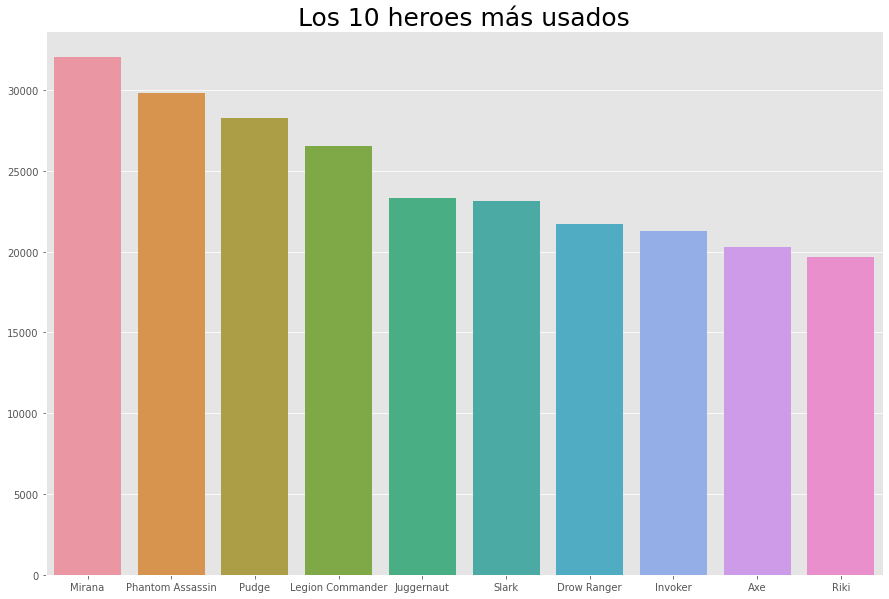

In [12]:
#Graficamos los 10 heroes mas usados.
fig=plt.figure(figsize=(15,10))
sns.barplot(x=list(sorted_heroes_count.keys())[:10],y=list(sorted_heroes_count.values())[:10])
plt.title('Los 10 heroes más usados',size=25)
plt.show()

### 10 heroes más usados por el equipo Radiant.

In [13]:
heroes_count_win={df_Heroes['localized_name'][h]:np.sum(df_dota_train[df_dota_train.iloc[:,h+4]==1].iloc[:,h+4]) for h in range(113)}
sorted_heroes_count_win=dict(sorted(heroes_count_win.items(),key=lambda item:item[1],reverse=True))

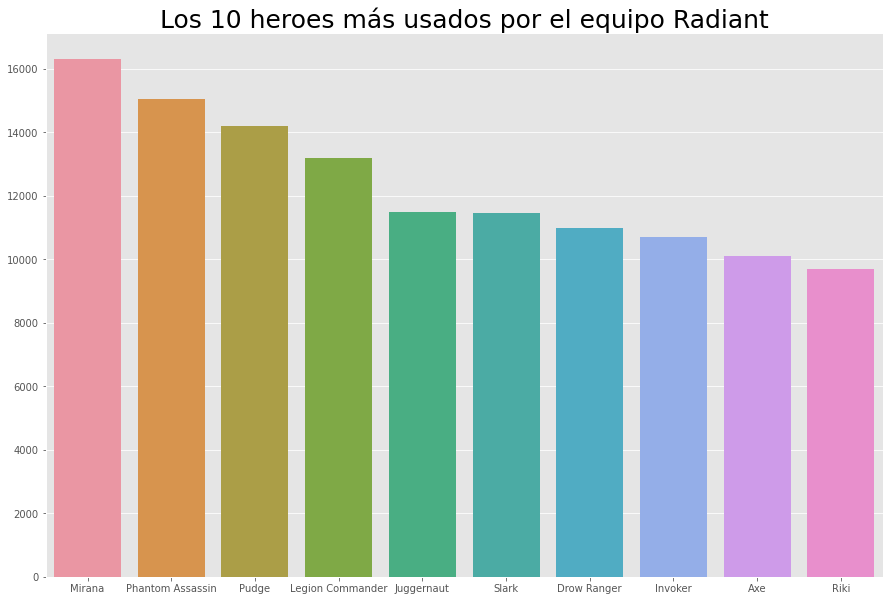

In [14]:
#Graficamos los 10 heroes mas usados por el equipo Radiant
fig=plt.figure(figsize=(15,10))
sns.barplot(x=list(sorted_heroes_count_win.keys())[:10],y=list(sorted_heroes_count_win.values())[:10])
plt.title('Los 10 heroes más usados por el equipo Radiant',size=25)
plt.show()

### Los 10 heroes mas usados por el equipo Dire

In [15]:
heroes_count_lose={df_Heroes['localized_name'][h]:np.abs(np.sum(df_dota_train[df_dota_train.iloc[:,h+4]==-1].iloc[:,h+4])) for h in range(113)}
sorted_heroes_count_lose=dict(sorted(heroes_count_lose.items(),key=lambda item:item[1],reverse=True))

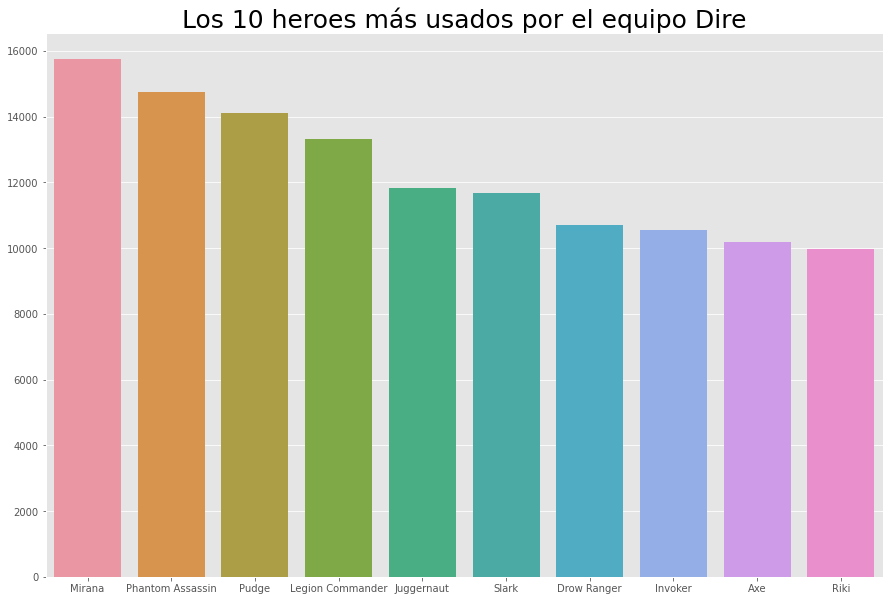

In [16]:
#Graficamos los 10 heroes mas usados por el equipo Dire.
fig=plt.figure(figsize=(15,10))
sns.barplot(x=list(sorted_heroes_count_lose.keys())[:10],y=list(sorted_heroes_count_lose.values())[:10])
plt.title('Los 10 heroes más usados por el equipo Dire',size=25)
plt.show()

## Realizamos one hot encoding de los datos.

### Formamos las entradas para el equipo Dire

In [17]:
df_Dire=df_dota_train.iloc[:,4:]

In [18]:
df_Dire.replace([1,-1],[0,1],inplace=True)

In [19]:
df_Dire.columns=['Dire_'+name for name in names_heroes]

In [20]:
df_dota_train.columns=['Winner','Region','Game_mode','Game_type']+ ['Radiant_'+name for name in names_heroes]

In [21]:
df_dota_train.replace(-1,0,inplace=True)

In [22]:
df_dota_train=pd.concat([df_dota_train,df_Dire],axis=1)

In [23]:
df_dota_train

,Winner,Region,Game_mode,Game_type,Radiant_antimage,Radiant_axe,Radiant_bane,Radiant_bloodseeker,Radiant_crystal_maiden,Radiant_drow_ranger,Radiant_earthshaker,Radiant_juggernaut,Radiant_mirana,Radiant_nevermore,Radiant_morphling,Radiant_phantom_lancer,Radiant_puck,Radiant_pudge,Radiant_razor,Radiant_sand_king,Radiant_storm_spirit,Radiant_sven,Radiant_tiny,Radiant_vengefulspirit,Radiant_windrunner,Radiant_zuus,Radiant_kunkka,Radiant_None,Radiant_lina,Radiant_lich,Radiant_lion,Radiant_shadow_shaman,Radiant_slardar,Radiant_tidehunter,Radiant_witch_doctor,Radiant_riki,Radiant_enigma,Radiant_tinker,Radiant_sniper,Radiant_necrolyte,...,Dire_invoker,Dire_silencer,Dire_obsidian_destroyer,Dire_lycan,Dire_brewmaster,Dire_shadow_demon,Dire_lone_druid,Dire_chaos_knight,Dire_meepo,Dire_treant,Dire_ogre_magi,Dire_undying,Dire_rubick,Dire_disruptor,Dire_nyx_assassin,Dire_naga_siren,Dire_keeper_of_the_light,Dire_wisp,Dire_visage,Dire_slark,Dire_medusa,Dire_troll_warlord,Dire_centaur,Dire_magnataur,Dire_shredder,Dire_bristleback,Dire_tusk,Dire_skywrath_mage,Dire_abaddon,Dire_elder_titan,Dire_legion_commander,Dire_ember_spirit,Dire_earth_spirit,Dire_abyssal_underlord,Dire_terrorblade,Dire_phoenix,Dire_techies,Dire_oracle,Dire_winter_wyvern,Dire_arc_warden
0,Dire,China,Captains Mode,Tournament,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Radiant,SoutheastAsia,Captains Mode,Tournament,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Radiant,EuropeWest,Captains Mode,Tournament,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Radiant,SoutheastAsia,Captains Mode,Tournament,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,Dire,Australia,Captains Mode,Tutorial,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92645,Dire,SoutheastAsia,Captains Mode,Tutorial,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
92646,Radiant,SoutheastAsia,Captains Mode,Tournament,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
92647,Radiant,USWest,Captains Mode,Tutorial,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
92648,Dire,Russia,Captains Mode,Tournament,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [24]:
df_dota_train.to_csv("drive/MyDrive/Colab Notebooks/dota_train_with_labels.csv")

### Filtrado de datos

* Eliminamos los modos de juego diferentes a All Pick, Ranked All Pick y Random Draft.
* Nos quedamos solo con el tipo de juego Tournament.

In [25]:
df_filter=df_dota_train.loc[(df_dota_train['Game_type']=='Tournament') & ((df_dota_train['Game_mode']=='All Pick') | (df_dota_train['Game_mode']=='Ranked All Pick') | (df_dota_train['Game_mode']=='Random Draft'))]

In [26]:
df_filter.head()

,Winner,Region,Game_mode,Game_type,Radiant_antimage,Radiant_axe,Radiant_bane,Radiant_bloodseeker,Radiant_crystal_maiden,Radiant_drow_ranger,Radiant_earthshaker,Radiant_juggernaut,Radiant_mirana,Radiant_nevermore,Radiant_morphling,Radiant_phantom_lancer,Radiant_puck,Radiant_pudge,Radiant_razor,Radiant_sand_king,Radiant_storm_spirit,Radiant_sven,Radiant_tiny,Radiant_vengefulspirit,Radiant_windrunner,Radiant_zuus,Radiant_kunkka,Radiant_None,Radiant_lina,Radiant_lich,Radiant_lion,Radiant_shadow_shaman,Radiant_slardar,Radiant_tidehunter,Radiant_witch_doctor,Radiant_riki,Radiant_enigma,Radiant_tinker,Radiant_sniper,Radiant_necrolyte,...,Dire_invoker,Dire_silencer,Dire_obsidian_destroyer,Dire_lycan,Dire_brewmaster,Dire_shadow_demon,Dire_lone_druid,Dire_chaos_knight,Dire_meepo,Dire_treant,Dire_ogre_magi,Dire_undying,Dire_rubick,Dire_disruptor,Dire_nyx_assassin,Dire_naga_siren,Dire_keeper_of_the_light,Dire_wisp,Dire_visage,Dire_slark,Dire_medusa,Dire_troll_warlord,Dire_centaur,Dire_magnataur,Dire_shredder,Dire_bristleback,Dire_tusk,Dire_skywrath_mage,Dire_abaddon,Dire_elder_titan,Dire_legion_commander,Dire_ember_spirit,Dire_earth_spirit,Dire_abyssal_underlord,Dire_terrorblade,Dire_phoenix,Dire_techies,Dire_oracle,Dire_winter_wyvern,Dire_arc_warden
184,Radiant,China,All Pick,Tournament,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
370,Radiant,Russia,Random Draft,Tournament,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
410,Radiant,China,All Pick,Tournament,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
450,Radiant,EuropeWest,Random Draft,Tournament,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
508,Radiant,EuropeEast,All Pick,Tournament,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [27]:
winners=list(df_filter['Winner'])
#Reetiquetamos a ganadores 1 gano Radiant, 0 gano Dire
y=[1 if winner=='Radiant' else 0 for winner in winners]

In [28]:
df_filter['Winner']=y

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [29]:
df_filter.head()

,Winner,Region,Game_mode,Game_type,Radiant_antimage,Radiant_axe,Radiant_bane,Radiant_bloodseeker,Radiant_crystal_maiden,Radiant_drow_ranger,Radiant_earthshaker,Radiant_juggernaut,Radiant_mirana,Radiant_nevermore,Radiant_morphling,Radiant_phantom_lancer,Radiant_puck,Radiant_pudge,Radiant_razor,Radiant_sand_king,Radiant_storm_spirit,Radiant_sven,Radiant_tiny,Radiant_vengefulspirit,Radiant_windrunner,Radiant_zuus,Radiant_kunkka,Radiant_None,Radiant_lina,Radiant_lich,Radiant_lion,Radiant_shadow_shaman,Radiant_slardar,Radiant_tidehunter,Radiant_witch_doctor,Radiant_riki,Radiant_enigma,Radiant_tinker,Radiant_sniper,Radiant_necrolyte,...,Dire_invoker,Dire_silencer,Dire_obsidian_destroyer,Dire_lycan,Dire_brewmaster,Dire_shadow_demon,Dire_lone_druid,Dire_chaos_knight,Dire_meepo,Dire_treant,Dire_ogre_magi,Dire_undying,Dire_rubick,Dire_disruptor,Dire_nyx_assassin,Dire_naga_siren,Dire_keeper_of_the_light,Dire_wisp,Dire_visage,Dire_slark,Dire_medusa,Dire_troll_warlord,Dire_centaur,Dire_magnataur,Dire_shredder,Dire_bristleback,Dire_tusk,Dire_skywrath_mage,Dire_abaddon,Dire_elder_titan,Dire_legion_commander,Dire_ember_spirit,Dire_earth_spirit,Dire_abyssal_underlord,Dire_terrorblade,Dire_phoenix,Dire_techies,Dire_oracle,Dire_winter_wyvern,Dire_arc_warden
184,1,China,All Pick,Tournament,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
370,1,Russia,Random Draft,Tournament,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
410,1,China,All Pick,Tournament,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
450,1,EuropeWest,Random Draft,Tournament,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
508,1,EuropeEast,All Pick,Tournament,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [30]:
df_=df_filter.drop(['Winner','Region','Game_mode','Game_type'],axis=1)

In [31]:
#df_.to_csv("drive/MyDrive/Colab Notebooks/dota_train_filter.csv")

In [32]:
#with open("drive/MyDrive/Colab Notebooks/filter_labels.csv",'w') as f:
#  wr=csv.writer(f)
#  wr.writerow(y)

### Hacemos onehot enconding para la region, modo y tipo de juego

In [33]:
#df_filter_onehot=pd.get_dummies(df_,prefix=['Region','Game_mode','Game_type'],columns=['Region','Game_mode','Game_type'])

In [34]:
#df_filter_onehot.head()

## Aplicamos MDS a los datos

In [35]:
%%R -i df_
require(ggplot2)

R[write to console]: Loading required package: ggplot2



In [36]:
%%R
#definimos la similaridad de Jaccard
J_similarity<-function(M,zero_division=0){
  J_matrix=matrix(nrow=nrow(M),ncol=nrow(M))
  for (i in 1:nrow(M)){
    for (j in i:nrow(M)){
      a=sum(M[i,] & M[j,])
      b=sum(!(!M[j,] | M[i,]))
      c=sum(!(!M[i,] | M[j,]))
      if(a+b+c==0){
        J_matrix[i,j]=zero_division
        J_matrix[j,i]=zero_division
      }
      if(a+b+c==0 & (i==j)){
        J_matrix[i,j]=1
      }
      else{
        J_matrix[i,j]= a/(a+b+c)  
        J_matrix[j,i]= a/(a+b+c)  
      }
    }
  }
  return(J_matrix)
}

In [37]:
%%R
X=as.matrix(df_)

In [38]:
%%R
sim_mat=J_similarity(X)
ones=rep(1,nrow(X))
D_J=2*(ones%*%t(ones)-sim_mat)

In [39]:
%%R
mds_SM=cmdscale(D_J,k=2,eig=TRUE,x.ret=TRUE)
pc=mds_SM$points
B=mds_SM$x

In [40]:
%%R -i df_filter

pc_df=data.frame(pc1=pc[,1],
                 pc2=pc[,2],
                 winner=df_filter$Winner,
                 region=df_filter$Region,
                 game_mode=df_filter$Game_mode,
                 game_type=df_filter$Game_type)

R[write to console]: Saving 8 x 8 in image



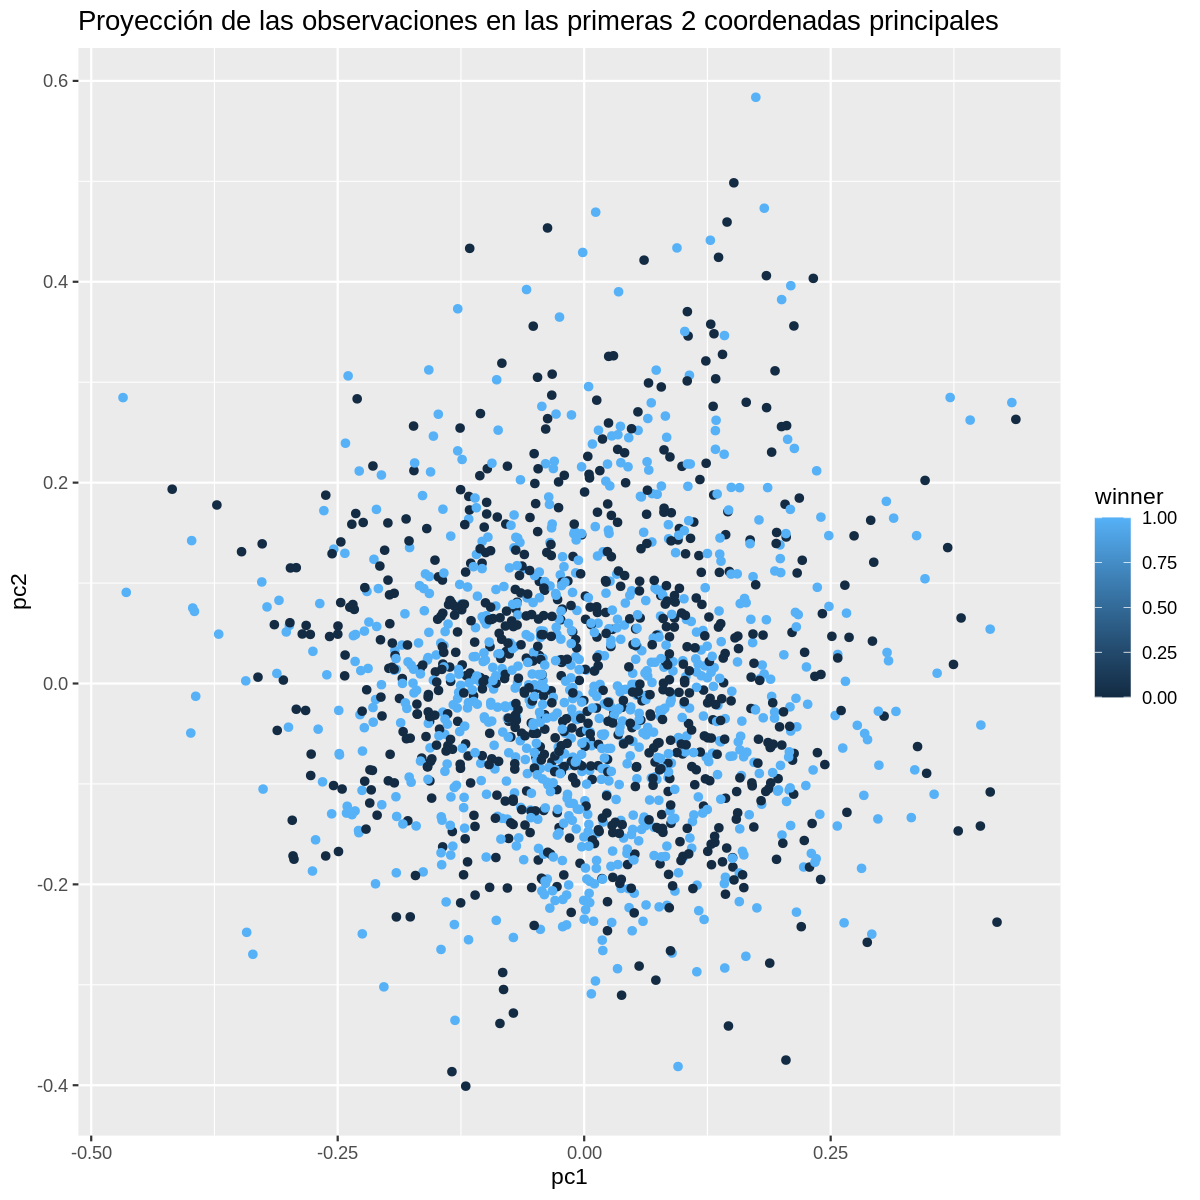

In [41]:
%%R -w 8 -h 8 --units in -r 150

ggplot(pc_df,aes(x=pc1,y=pc2,col=winner))+
 geom_point()+
 ggtitle("Proyección de las observaciones en las primeras 2 coordenadas principales")+
 ggsave("mds2.png")

## Proponemos un clasificador LDA

In [42]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [43]:
pc=np.array(robjects.reval("pc"))

In [44]:
clf=lda=LinearDiscriminantAnalysis()
clf.fit(pc,y)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [45]:
y_pred=clf.predict(pc)

In [46]:
from sklearn.metrics import confusion_matrix,classification_report

In [47]:
cm=confusion_matrix(y,y_pred)

In [48]:
report=classification_report(y,y_pred,output_dict=True)
print(classification_report(y,y_pred))

              precision    recall  f1-score   support

           0       0.52      0.07      0.12       742
           1       0.54      0.95      0.69       873

    accuracy                           0.54      1615
   macro avg       0.53      0.51      0.40      1615
weighted avg       0.53      0.54      0.43      1615



In [49]:
df_report=pd.DataFrame(report).transpose()
df_report.to_latex(float_format='%.2f')

'\\begin{tabular}{lrrrr}\n\\toprule\n{} &  precision &  recall &  f1-score &  support \\\\\n\\midrule\n0            &       0.52 &    0.07 &      0.12 &   742.00 \\\\\n1            &       0.54 &    0.95 &      0.69 &   873.00 \\\\\naccuracy     &       0.54 &    0.54 &      0.54 &     0.54 \\\\\nmacro avg    &       0.53 &    0.51 &      0.40 &  1615.00 \\\\\nweighted avg &       0.53 &    0.54 &      0.43 &  1615.00 \\\\\n\\bottomrule\n\\end{tabular}\n'

## Clasificamos los datos de prueba

In [50]:
def project(d):
  
  B=np.array(robjects.reval("B"))
  u,s,vh=np.linalg.svd(B)
  Lambda=np.diag(s)
  Lambda_inv=np.linalg.inv(Lambda)
  X_=u@np.sqrt(Lambda)
  return (1/2)*Lambda_inv@X_.T@(np.diag(B)-d)


In [51]:
mv mds2.png drive/MyDrive/Colab\ Notebooks